# Distributional Repair Algorithm

The distributional repair algorithm is adapted from the work of Abigail Langbridge et al.
https://arxiv.org/pdf/2403.13864

This algorithm learns an optimal transport plan from the privileged and unprivileged groups to the barycentre between them. This plan can then be applied to either the training data or the test data to repair the dataset under the notion of conditional independence.

In [1]:
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.algorithms.preprocessing.distributional_repair import DistributionalRepair
# from aif360.algorithms.preprocessing.pointwise_repair import PointwiseRepair

from aif360.datasets import AdultDataset
import numpy as np
import pandas as pd
import ot
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# from tqdm import tqdm
# import time

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


This demo file uses the adult dataset to demonstrate the distributional repair algorithm.

In [ ]:
def load_adult_dataset(s,u,x,y):
    def custom_preprocessing(df):
        pd.set_option('future.no_silent_downcasting', True)
        def group_race(x):
            if x == "White":
                return 1.0
            else:
                return 0.0

        df['race'] = df['race'].apply(lambda x: group_race(x))

        # Encode 'sex' column as numerical values
        df['sex'] = df['sex'].map({'Female': 0.0, 'Male': 1.0})

        df['Income Binary'] = df['income-per-year']
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K.', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K.', value=0, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K', value=0, regex=True)
        # 1 if education-num is greater than 9, 0 otherwise
        df['college_educated'] = (df['education-num'] > 9).astype(int)

        # drop nan columns
        df = df.dropna()

        return df

    adult = AdultDataset(
        label_name=y,
        favorable_classes=[1,1],
        protected_attribute_names=[s],
        privileged_classes=[[1.0]],
        instance_weights_name=None,
        categorical_features=[],
        features_to_keep=[s]+[u]+x,
        na_values=[],
        custom_preprocessing=custom_preprocessing,
        features_to_drop=[],
        metadata={}
    )
    return adult

KL divergence is used as the distance metric between the original and repaired data distributions. Is calculated for each feature, with the the average KL divergence across all features used as the final distance metric, U-Mean KLD.

In [3]:
def _eval_kld(x_0, x_1):
    support = np.linspace(np.min([np.min(x_0), np.min(x_1)]), np.max([np.max(x_0), np.max(x_1)]), 500).reshape(-1,1)
    kde_0 = KernelDensity(kernel='gaussian',bandwidth='silverman').fit(x_0.reshape(-1,1))
    pmf_0 = np.exp(kde_0.score_samples(support)) 
    #add a small value to avoid division by zero
    pmf_0 += 1e-10
    kde_1 = KernelDensity(kernel='gaussian',bandwidth='silverman').fit(x_1.reshape(-1,1))
    pmf_1 = np.exp(kde_1.score_samples(support))
    pmf_1 += 1e-10
    return - np.sum(pmf_0 * np.log(pmf_1 / pmf_0))

def eval_kld(x, s, u, order=[0,1]):
    tot_kld = 0.0
    for u_val, u_count in u.value_counts().items():
        mask_0 = np.asarray((u == u_val) & (s == 0))
        mask_1 = np.asarray((u == u_val) & (s == 1))
        if (np.sum(mask_0) == 0) or (np.sum(mask_1) == 0):
            continue
        tmp = _eval_kld(x[mask_0].values, x[mask_1].values)
        if np.isnan(tmp):
            continue
        tot_kld += tmp * u_count / len(u)
    return tot_kld

## Parameters for Distributional Repair Algorithm

- `n_q` is the number of support points for the probability distribution function. This defaults to 250, however this can be increased to improve the accuracy of the repair algorithm.
  
- `S` is the protected or sensitive attribute for which the repair is against

- `U` the name of the unprotected attribute. This should not be a sensitive attribute, or be used later by a model to predict the outcome.

- `X` is a list of features used by the model to make its predictions. This should not include the sensitive attribute.

- `X_continuous` is a list of continuous features in `X`

- `Y` is the outcome of a model, which is predicted using the features in `X`. This should be a binary outcome.

In [4]:
n_R = 10000 # number of points in the research dataset
n_q = 250 # number of supports under the estimated pdfs

S = 'sex'
U = 'college_educated'
X = ['age','hours-per-week']
X_continuous= ['age','hours-per-week']
Y = 'Income Binary'

## Step 1: Split the data into a research and archive set

The research dataset can be considered similar to the 'training set' for our fairness repair. The 'test set' is the remaining data, unseen by the repair algorithm.

In [5]:
data = load_adult_dataset(S,U,X,Y)

dataset_R, dataset_A = data.split([n_R], shuffle=True)

## Step 2: Initialise the repair algorithm and transform the data

The Distributional Repair Algorithm is initialised and fit based on research dataset for speed.

It can then be used to transform both seen and unseen data.

In [6]:
dist_repair = DistributionalRepair(S,U,X,Y,X_continuous,n_q)
dist_repair.fit(dataset_R)

dataset_A_repaired = dist_repair.transform(dataset_A)
dataset_R_repaired = dist_repair.transform(dataset_R)

## Evaluating the repair algorithm

We evaluate the *quality* of the repair based on the mean [Kullback-Liebler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the classes of the protected attribute.

A lower KLD means that the two classes' data are close together, which means the repair has been successful in reducing the ability to distinguish between different protected attributes from the other data!

In [7]:
tilde_x_R = dataset_R_repaired.convert_to_dataframe()[0][X]
tilde_x_A = dataset_A_repaired.convert_to_dataframe()[0][X]

kld_x_R = np.zeros(shape=(len(X), 2))
kld_x_tilde_R = np.zeros(shape=(len(X), 2))
kld_x_A = np.zeros(shape=(len(X), 2))
kld_x_tilde_A = np.zeros(shape=(len(X), 2))

pos = np.arange(len(X))
for i, feat in enumerate(X):
    kld_x_R[i, 0] = eval_kld(dist_repair.x_R[feat], dist_repair.s_R, dist_repair.u_R, order=[0, 1])
    kld_x_R[i, 1] = eval_kld(dist_repair.x_R[feat], dist_repair.s_R, dist_repair.u_R, order=[1, 0])

    kld_x_tilde_R[i, 0] = eval_kld(tilde_x_R[feat], dist_repair.s_R, dist_repair.u_R, order=[0, 1])
    kld_x_tilde_R[i, 1] = eval_kld(tilde_x_R[feat], dist_repair.s_R, dist_repair.u_R, order=[1, 0])

    kld_x_A[i, 0] = eval_kld(dataset_A.convert_to_dataframe()[0][X][feat], dataset_A.convert_to_dataframe()[0][S], dataset_A.convert_to_dataframe()[0][U], order=[0, 1])
    kld_x_A[i, 1] = eval_kld(dataset_A.convert_to_dataframe()[0][X][feat], dataset_A.convert_to_dataframe()[0][S], dataset_A.convert_to_dataframe()[0][U], order=[1, 0])

    kld_x_tilde_A[i, 0] = eval_kld(tilde_x_A[feat], dataset_A.convert_to_dataframe()[0][S], dataset_A.convert_to_dataframe()[0][U], order=[0, 1])
    kld_x_tilde_A[i, 1] = eval_kld(tilde_x_A[feat], dataset_A.convert_to_dataframe()[0][S], dataset_A.convert_to_dataframe()[0][U], order=[1, 0])
    
kld_x_A_mean = np.mean(kld_x_A, axis=1)
kld_x_tilde_A_mean = np.mean(kld_x_tilde_A, axis=1)
kld_x_R_mean = np.mean(kld_x_R, axis=1)
kld_x_tilde_R_mean = np.mean(kld_x_tilde_R, axis=1)

## Plotting the results

The plot below demonstrates how the repair algorithm has performed. Successful repair is indicated by the repaired scores (green) being lower than the original scores (red).

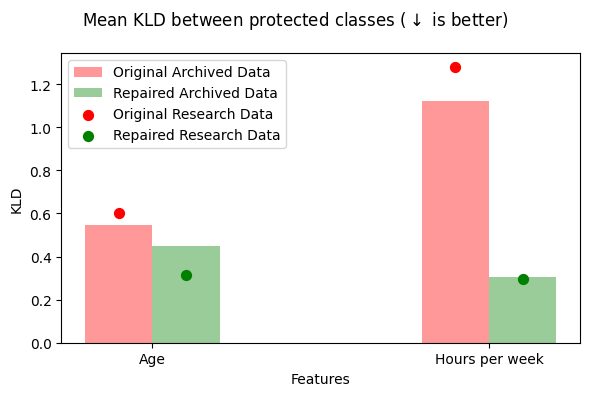

In [8]:
fig, ax = plt.subplots(figsize=(6,4))

bar_width = 0.2
original_color = 'red'
repaired_color = 'green'

original_bars = ax.bar(x=pos - bar_width/2, height=kld_x_A_mean, width=bar_width, alpha=0.4, color=original_color)
repaired_bars = ax.bar(x=pos + bar_width/2, height=kld_x_tilde_A_mean, width=bar_width, alpha=0.4, color=repaired_color)
original_scatter = ax.scatter(x=pos - bar_width/2, y=kld_x_R_mean, color=original_color, marker='o', s=50)
repaired_scatter = ax.scatter(x=pos + bar_width/2, y=kld_x_tilde_R_mean, color=repaired_color, marker='o', s=50)

x_labels = [x.replace('-', ' ').capitalize() for x in X]
ax.set_xticks(pos)
ax.set_xticklabels(x_labels)

handles = [original_bars, repaired_bars, original_scatter, repaired_scatter]
labels = ['Original Archived Data', 'Repaired Archived Data', 'Original Research Data', 'Repaired Research Data']

ax.legend(handles, labels, loc='upper left')
ax.set_ylabel("KLD")
ax.set_xlabel("Features")

fig.suptitle(r"Mean KLD between protected classes ($\downarrow$ is better)")
plt.tight_layout()
plt.show()


## Using the Repaired Data

Here, we demonstrate the key property of distributional repair -- that predictive performance is minimally effected by the fairness repair.

We train a simple LogisticRegression model on the original and repaired data, and demonstrate that the performance is maintained.

In [9]:
orig_features = np.vstack([dataset_R.features, dataset_A.features])
repaired_features = np.vstack([dataset_R_repaired.features[:, [0, 2, 1, 3]], dataset_A_repaired.features[:, [0, 2, 1, 3]]])

labels = np.vstack([dataset_R.labels, dataset_A.labels]).reshape(-1,)

In [10]:
train_feats, test_feats, train_labels, test_labels = train_test_split(orig_features, labels, random_state=24)
repaired_train_feats, repaired_test_feats, _, _ = train_test_split(repaired_features, labels, random_state=24)

In [12]:
model = LogisticRegression()

# original data
model.fit(train_feats, train_labels)
original_pred = model.predict(test_feats)
original_f1 = f1_score(y_true=test_labels, y_pred=original_pred)

# repaired data
model.fit(repaired_train_feats, train_labels) # datasets are in same order so can reuse labels
repaired_pred = model.predict(repaired_test_feats)
repaired_f1 = f1_score(y_true=test_labels, y_pred=repaired_pred)

print(f"Original Data: {original_f1:.3f}")
print(f"Repaired Data: {repaired_f1:.3f}")

Original Data: 0.391
Repaired Data: 0.393
